# Object Detection 
The purpose of this notebook is to outline bounding boxes on big tiles to support object detection. The notebook also allows for the reading of TensorFlow records.

## Datasets Description 
- **Big Tiles Image Folder**: A folder storing .tif images, each with unique IDs 
- **XView GeoJSON File**: 
    - **type**: “Feature” for every row, since each row describes a bounding box or a feature of the tif file
    - **properties**:
        - **uniqueid**: An unique number for each bounding box
        - **type**: ADD
        - **Joined lay**: The tif file that corresponds to the image
        - **bb**: The vertices of the bounding box in pixels, in the format (xmin, ymin, xmax, ymax). If the tif file is not present in the            user’s system, this value is set to null.
    - **geometry**: 
        - **type**: “Polygon” for every row, since the bounding box is defined by multiple vertices
        - **coordinates**: The vertices of the bounding box in latitude/longitude, in the format (xmin, ymin, xmax, ymax)
- **TensorFlow Record Chipped Data**: Each TensorFlow Record is identified by the name of the tif file it holds the data for.

## Libraries Installation
Ensure the libraries required for this notebook are installed as well as the FreeSerfif.tff font. The font is used to draw the bounding boxes and can be changed based on user preference. 

In [1]:
pip install pillow matplotlib numpy scikit-image rasterio pandas tqdm tensorflow

Note: you may need to restart the kernel to use updated packages.


## Processing an xView GeoJSON file

**Requirements:** 
- A GeoJSON file formatted as detailed in the Datasets Description section as input.

**Design Preferences:**
* Bounding boxes can be resized by varying the x_buffer, y_buffer, and right_shift
    * **offset_vector = [xmin, ymin, xmax, ymax]** and must follow that **xmin < xmax** and **ymin < ymax**

In [333]:
from PIL import ImageFont
import matplotlib.pyplot as plt
import numpy as np
import csv
import skimage
from skimage.io import imread
import rasterio
import pandas
import json
from tqdm import tqdm
%matplotlib inline

In [334]:
# Processes an xView GeoJSON file
# INPUT: filepath to the GeoJSON file
# OUTPUT: Bounding box coordinate array, Chip-name array, and Class-id array
def get_labels_w_uid(fname):
    """
    Gets label data from a geojson label file
    Args:
        fname: file path to an xView geojson label file
    Output:
        Returns three arrays: coords, chips, and classes corresponding to the
            coordinates, file-names, and classes for each ground truth.
    """
    x_buffer = 15
    y_buffer = 15
    right_shift = 5 # how much shift to the right 
    offset_vector = np.array([-x_buffer + right_shift, y_buffer, x_buffer + right_shift, -y_buffer])  # shift to the right
    with open(fname) as f:
        data = json.load(f)
    coords = np.zeros((len(data['features']),4))
    chips = np.zeros((len(data['features'])),dtype="object")
    classes = np.zeros((len(data['features'])))
    uids = np.zeros((len(data['features'])))
    for i in tqdm(range(len(data['features']))):
        if data['features'][i]['properties']['bb'] != []:
            try:
                b_id = data['features'][i]['properties']['Joined lay']
                bbox = data['features'][i]['properties']['bb'][1:-1].split(",")
                val = np.array([int(num) for num in data['features'][i]['properties']['bb'][1:-1].split(",")])
                # SWAPPED VALUES. Why did the values swap?
                # ymin = val[3]
                # ymax = val[1]
                # val[1] =  ymin
                # val[3] = ymax
                chips[i] = b_id
                classes[i] = data['features'][i]['properties']['type']
                uids[i] = int(data['features'][i]['properties']['uniqueid'])
            except:
                  pass
            if val.shape[0] != 4:
                print("Messed up: %d!" % i)
            else:
                coords[i] = val
        else:
            chips[i] = 'None'

    # coords = np.add(coords, offset_vector)

    return coords, chips, classes, uids

In [335]:
coords, chips, classes, uids = get_labels_w_uid('../dssg_data/harvey_ms_2class_fixedprecision.geojson')

100%|███████████████████████████████| 126937/126937 [00:00<00:00, 532708.55it/s]


In [336]:
print(coords[1000], chips[1000], classes[1000], uids[1000])

[ 324. 1107.  360. 1140.] 20170829_1040010032211E00_2110200_jpeg_compressed_03_09.tif 2.0 1025.0


## Drawing Bounding Boxes

**Requirements:** 
- An images folder containing big tiles formatted as detailed in the Datasets Description section as input.
- A .tif image from the images folder 

**Design Preferences:**
- font style and size for bounding boxes

In [441]:
import numpy as np
from PIL import Image
import tensorflow as tf
from PIL import Image, ImageDraw
import skimage.filters as filters
from PIL import Image, ImageFont, ImageDraw, ImageEnhance



In [442]:
def draw_bboxes_withindex(img, boxes):
    """
    A helper function to draw bounding box rectangles on images
    Args:
        img: image to be drawn on in array format
        boxes: An (N,4) array of bounding boxes
    Output:
        Image with drawn bounding boxes
    """
    source = Image.fromarray(img)
    draw = ImageDraw.Draw(source)
    w2,h2 = (img.shape[0],img.shape[1])
    
    font = ImageFont.truetype('/usr/share/fonts/truetype/freefont/FreeSerif.ttf', 15)
    #font = ImageFont.truetype('arial.ttf', 24)

    idx = 0

    for b in boxes:
        xmin,ymin,xmax,ymax = b
        
        for j in range(3):
            draw.rectangle(((xmin+j, ymin+j), (xmax+j, ymax+j)), outline="red")
        idx +=1
    return source



../dssg_data/image_tiles_aws/20170829_1040010032211E00_2110200_jpeg_compressed_03_09.tif
(3, 2048, 2048)


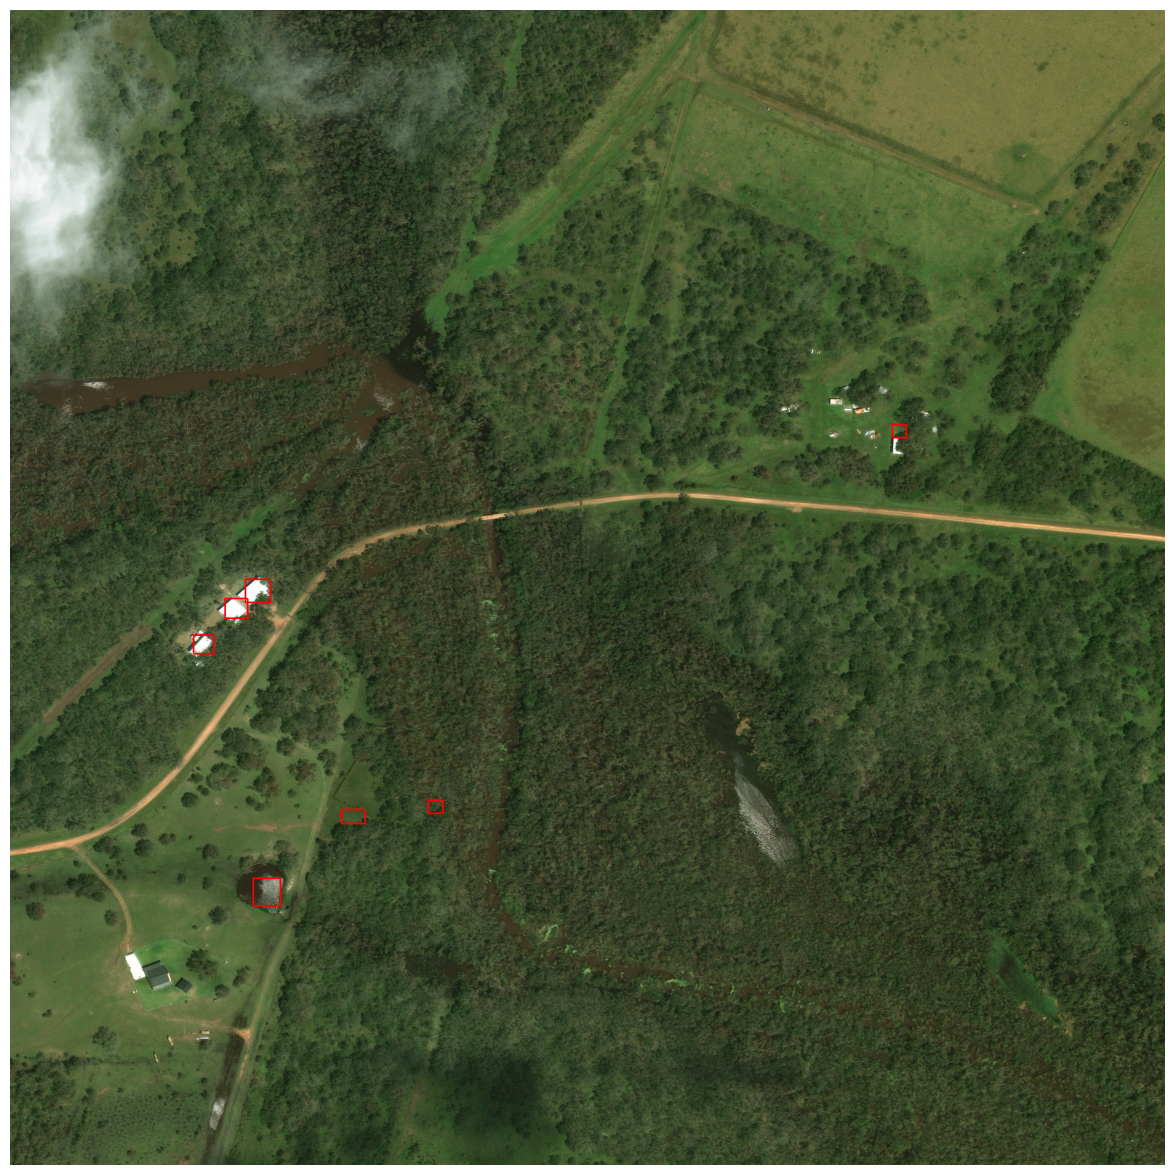

In [443]:
#Load an image
path = '../dssg_data/image_tiles_aws/'
chip_name = '20170829_1040010032211E00_2110200_jpeg_compressed_03_09.tif'
# chip_name = '20170831_105001000B95E100_2131131_jpeg_compressed_02_09.tif'

chip_fullname = path + chip_name
print(chip_fullname)

with rasterio.open(chip_fullname, "r") as r:
    arr = r.read()
    print(arr.shape)
    arr = np.moveaxis(arr,0,2)
    coords_chip = coords[chips==chip_name]
    classes_chip = classes[chips==chip_name].astype(np.int64)
    uids_chip = uids[chips == chip_name].astype(np.int64)
    labelled = draw_bboxes_withindex(arr, coords_chip)
    
    plt.figure(figsize=(15,15))
    plt.axis('off')
    plt.imshow(labelled)

# print(arr.shape)
# plt.figure(figsize=(10,10))
# plt.axis('off')
# plt.imshow(arr)

## Reading TensorFlow Records

**Requirements:** 
- Chipped data formatted as detailed in the Datasets Description section as input.

In [444]:
import tensorflow as tf
print(tf.executing_eagerly())

True


In [445]:
tfds = tf.data.TFRecordDataset(
    r'../dssg_data/harvey_train_t1_chipped.record',
    compression_type=None,
    buffer_size=None,
    num_parallel_reads=None,
)

In [446]:
def parse_fn(data_record):
    feature = {'image/encoded': tf.io.FixedLenFeature([], tf.string),
               'image/object/class/label': tf.io.FixedLenFeature([], tf.int64),
               'image/height': tf.io.FixedLenFeature([], tf.int64),
               'image/width': tf.io.FixedLenFeature([], tf.int64),
               'image/encoded': tf.io.FixedLenFeature([], tf.string),
               'image/format': tf.io.FixedLenFeature([], tf.string),
               'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
               'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
               'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
               'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
               'image/object/class/text': tf.io.VarLenFeature(tf.string),
               'image/object/class/label': tf.io.VarLenFeature(tf.int64)
                }
    sample = tf.io.parse_single_example(data_record, feature)
    return(sample)

In [447]:
# loop through examples and stack them in a list of dictionaries
d_list = []

for raw_record in tfds.take(2):
    example = tf.train.Example()
    try: 
        parsed_example = parse_fn(raw_record)
        encoded_image = parsed_example['image/encoded']
        decoded_image = tf.image.decode_jpeg(encoded_image, channels=3)
        d = {}
        d['image/decoded'] = decoded_image  
        d['image/object/class/label'] = parsed_example['image/object/class/label'].values.numpy()
        d['image/object/bbox/xmin'] = parsed_example['image/object/bbox/xmin'].values.numpy()
        d['image/object/bbox/xmax'] = parsed_example['image/object/bbox/xmax'].values.numpy()
        d['image/object/bbox/ymin'] = parsed_example['image/object/bbox/ymin'].values.numpy()
        d['image/object/bbox/ymax'] = parsed_example['image/object/bbox/ymax'].values.numpy()
        print(d)
    except Exception as e:
        print(e)
        print("error parsing")
        pass
    d_list.append(d)

{'image/decoded': <tf.Tensor: shape=(300, 300, 3), dtype=uint8, numpy=
array([[[143, 152, 135],
        [167, 176, 157],
        [175, 184, 165],
        ...,
        [146, 147, 129],
        [144, 145, 127],
        [142, 143, 125]],

       [[176, 185, 168],
        [159, 168, 149],
        [193, 202, 181],
        ...,
        [154, 155, 137],
        [151, 152, 134],
        [148, 149, 131]],

       [[166, 173, 155],
        [170, 177, 159],
        [194, 202, 179],
        ...,
        [147, 146, 128],
        [145, 144, 126],
        [142, 141, 123]],

       ...,

       [[135, 131, 106],
        [133, 129, 104],
        [134, 130, 105],
        ...,
        [121, 117,  92],
        [119, 115,  90],
        [119, 115,  90]],

       [[134, 130, 105],
        [132, 128, 103],
        [133, 129, 104],
        ...,
        [119, 115,  90],
        [118, 114,  89],
        [118, 114,  89]],

       [[126, 122,  97],
        [126, 122,  97],
        [129, 125, 100],
        ...,
   

## Creating 300x300 Chips
### wv_utils Library (As Done in process_dssg.ipynb)
**Requirements:**
- Coordinates for specific image
- Classes for specific image

**Design Preferences**
- Size of chips (currently 300x300)

In [448]:
pip install wvutils

Note: you may need to restart the kernel to use updated packages.


In [449]:
import wv_util as wv
import aug_util as aug

In [450]:
# Only want the coordinates and classes that are within our image
coords_chip = coords[chips==chip_name]
classes_chip = classes[chips==chip_name].astype(np.int64)

In [451]:
# Chip the image into 300x300 chips
c_img, c_box, c_cls = wv.chip_image(img = arr, coords=coords_chip, classes=classes_chip, shape=(300,300))
print("Num Chips: %d" % c_img.shape[0])

Num Chips: 36


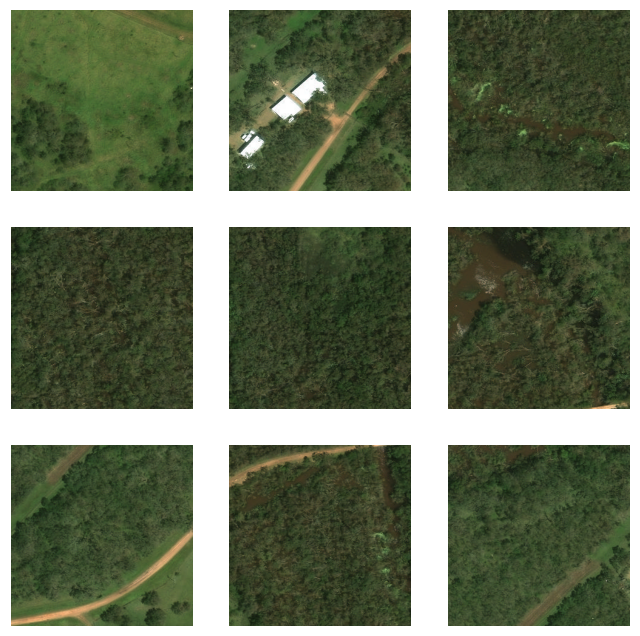

In [452]:
#Plots some of the chips
fig,ax = plt.subplots(1)
fig.set_figheight(8)
fig.set_figwidth(8)
ax.set_axis_off()

for k in range(9):
    plt.subplot(3,3,k+1)
    plt.axis('off')
    plt.imshow(c_img[np.random.choice(range(c_img.shape[0]))])

# when specifically running this chip '20170829_1040010032211E00_2110200_jpeg_compressed_03_09.tif' to view in geometric order
# curr_chip = 0; 
# for col in range(0, 6): 
#     for row in range(0, 6):
#         plt.subplot(6, 6, (col+1) + row*6)
#         plt.axis('off')
#         plt.imshow(c_img[curr_chip])
#         curr_chip += 1;
plt.show()

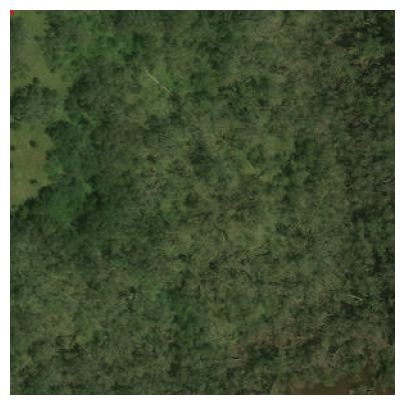

In [453]:
# Plots the bounding boxes, if any, over a 300x300 chip 
ind = np.random.choice(range(c_img.shape[0]))
labelled = aug.draw_bboxes(c_img[ind], c_box[ind])
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(labelled)

### Patchify Library 
**Requirements:**
- An image from a bigger tile

**Design Preferences**
- Size of chips (currently 300x300)

In [454]:
pip install patchify shapely

Note: you may need to restart the kernel to use updated packages.


In [455]:
from patchify import patchify, unpatchify
from shapely.geometry import box

In [456]:
# Only want the coordinates that are within our image
coords_chip = coords[chips==chip_name]

c_imgs = patchify(arr, c_size, step=300)
print(c_imgs.shape)
print("Num Chips:", patches.shape[0]*patches.shape[1])

(6, 6, 1, 300, 300, 3)
Num Chips: 36


In [457]:
def find_bboxes(c_imgs):
    """
        Finds bounding boxes for each chip. 
    Args:
        c_imgs: patchify array containing chips.
    Output:
        Returns a 2D list of the coordinates of bounding boxes for each chip. The 2D list maps to the 
        c_imgs array such that c_imgs.shape[0]==len(chip_boxes) and c_imgs.shape[1]==len(chip_boxes[0])
    """
    chip_boxes = [[0 for x in range(c_imgs.shape[1])] for y in range(c_imgs.shape[0])] 
    c_size = (c_imgs.shape[3], c_imgs.shape[4], c_imgs.shape[5])
    
    for row in range(c_imgs.shape[0]):
        for col in range(c_imgs.shape[1]):
            c_img = c_imgs[row, col, 0]
            chip_box = box(col * c_size[1], row * c_size[0], (col + 1) * c_size[1], (row + 1) * c_size[0])
            chip_bboxs = []
            
            for coord in coords_chip:
                obj_bbox = box(coord[0], coord[1], coord[2], coord[3])
                if chip_box.intersects(obj_bbox):
                    chip_bboxs.append([coord[0] - col * c_size[1], coord[1] - row * c_size[0], 
                                       coord[2] - col * c_size[1], coord[3] - row * c_size[0]])
            
            chip_boxes[row][col] = chip_bboxs
            
    return chip_boxes

In [458]:
# Find bounding boxes
c_bbs = find_bboxes(c_imgs)

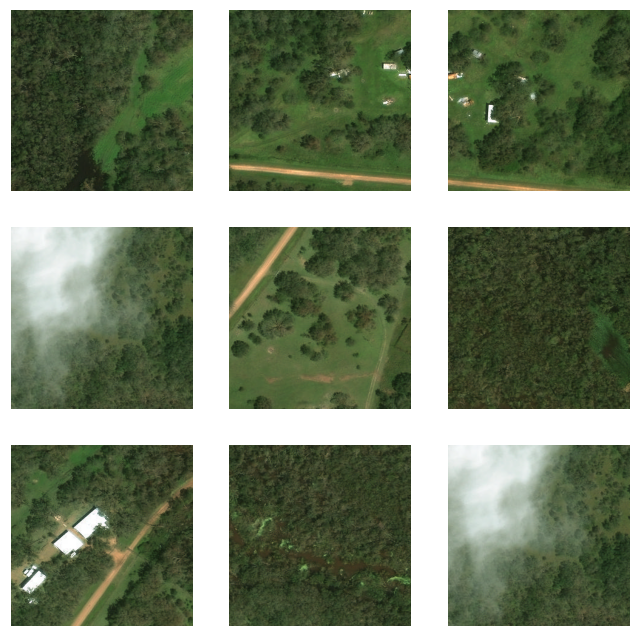

In [459]:
# Plot some of the chips
fig,ax = plt.subplots(1)
fig.set_figheight(8)
fig.set_figwidth(8)
ax.set_axis_off()

for k in range(9):
    plt.subplot(3,3,k+1)
    plt.axis('off')
    plt.imshow(c_imgs[np.random.choice(range(c_imgs.shape[0])), np.random.choice(range(c_imgs.shape[1])), 0])

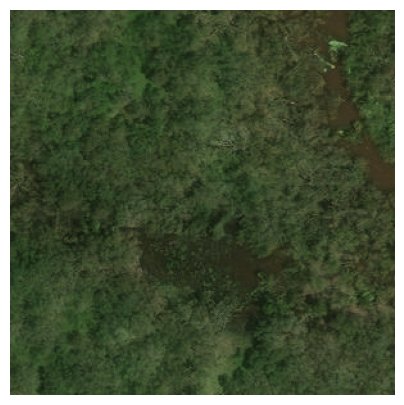

In [460]:
# Plots the bounding boxes, if any, over a 300x300 chip 

# Select a chip 
row = np.random.choice(range(c_imgs.shape[0]))
col = np.random.choice(range(c_imgs.shape[1]))
curr_c = c_imgs[row, col, 0]

labelled = draw_bboxes_withindex(curr_c, c_bbs[row][col])
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(labelled)